In [24]:
from astropy.io import fits
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob

import scipy.stats as ss

import sys
sys.path.insert(0, '../util/')
from util_os import util_os

In [2]:
matplotlib.rc('font', family='serif')
rcParams['axes.linewidth'] = 3
rcParams['xtick.major.width'] = 3
rcParams['xtick.major.size'] = 12
rcParams['ytick.major.width'] = 3
rcParams['ytick.major.size'] = 12

rcParams['xtick.minor.width'] = 2
rcParams['xtick.minor.size'] = 8
rcParams['ytick.minor.width'] = 2
rcParams['ytick.minor.size'] = 8

rcParams['font.family'] = 'serif'

rcParams['text.usetex'] = False

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.transparent'] = False

# Set up 

In [16]:
# for keck 
fit = fits.open('keck_breathing_mode_dwarfs_v2.5.fits')
data = fit[1].data

qualitymask = data['quality']>=1

ssfr_keck = data['ssfr'][qualitymask] # log
mass_keck = data['mass'][qualitymask] #log 
vdisp_keck= data['vdisp_corr'][qualitymask]
hlr_keck  = data['R50_kpc'][qualitymask]
z_keck = data['redshift_keck'][qualitymask]

# make cuts for ssfr and sigma 
ssfr_min = -11
ssfr_max = -8

sigma_min = 0
sigma_max = 100

# cut on ssfr 
ssfrmask = ssfr_keck>=ssfr_min

z_cut = z[ssfrmask]
ssfr_keck_cut = ssfr_keck[ssfrmask]
vdisp_keck_cut = vdisp_keck[ssfrmask]
hlr_keck_cut = hlr_keck[ssfrmask]
mass_keck_cut = mass_keck[ssfrmask]

ssfrmask = ssfr_keck_cut<=ssfr_max

z_cut = z_cut[ssfrmask]
ssfr_keck_cut = ssfr_keck_cut[ssfrmask]
vdisp_keck_cut = vdisp_keck_cut[ssfrmask]
hlr_keck_cut = hlr_keck_cut[ssfrmask]
mass_keck_cut = mass_keck_cut[ssfrmask]

# cut on sigma 
sigmamask = vdisp_keck_cut>sigma_min

z_cut = z_cut[sigmamask]
ssfr_keck_cut = ssfr_keck_cut[sigmamask]
vdisp_keck_cut = vdisp_keck_cut[sigmamask]
hlr_keck_cut = hlr_keck_cut[sigmamask]
mass_keck_cut = mass_keck_cut[sigmamask]

sigmamask = vdisp_keck_cut<sigma_max

z_cut = z_cut[sigmamask]
ssfr_keck_cut = ssfr_keck_cut[sigmamask]
vdisp_keck_cut = vdisp_keck_cut[sigmamask]
hlr_keck_cut = hlr_keck_cut[sigmamask]
mass_keck_cut = mass_keck_cut[sigmamask]

In [17]:
# for fire
datapath_fire = '/home/jw1624/H1-merian/fire/csvs'
galfiles_fire = glob.glob(datapath_fire+'/*.txt')
galfiles_fire.sort()

galnames_fire = ['m11b', 'm11d', 'm11e', 'm11h', 'm11i', 'm11q']

In [28]:
# for romulus
datapath_romulus = '/home/jw1624/H1-merian/csvs/breathingModes_clean/'

galaxies_romulus = util_os.getGalaxies()[0]

# First, Overplot FIRE and Keck

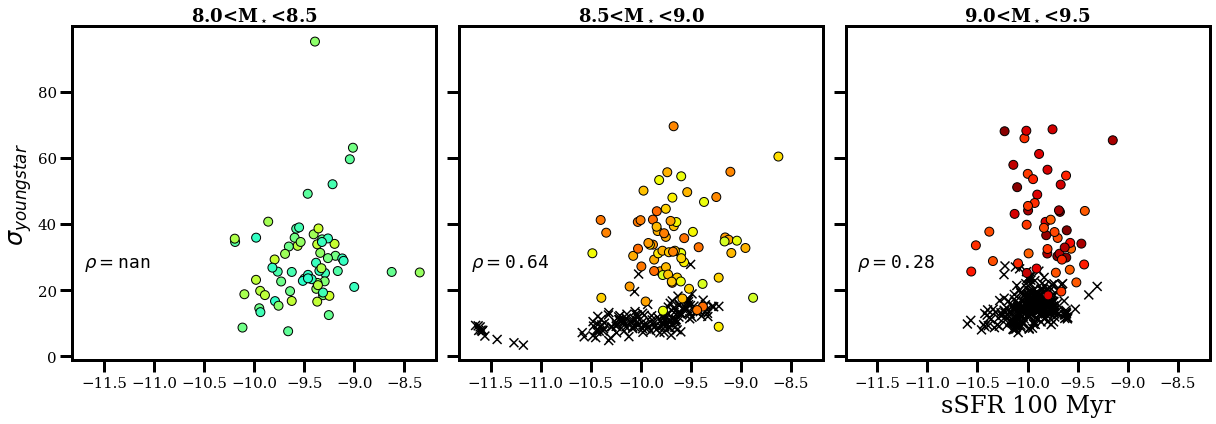

In [21]:
# SIG
fig, axs = plt.subplots(1,3, figsize=(17,6), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [8.0,8.5,9.0,9.5]

for i,ax in enumerate(axs):
    ssfr = []
    sigYS = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galfiles_fire[1:]):
        
        data = pd.read_csv(gal)
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_youngstar_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigYS.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigYS, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

    massmask = mass_keck_cut >= mstar_min
    mm = mass_keck_cut[massmask]
    x = ssfr_keck_cut[massmask]
    y = vdisp_keck_cut[massmask]

    massmask = mm<=mstar_max
    mm = mm[massmask]
    x = x[massmask]
    y = y[massmask]

    s=ax.scatter(x, y, c=mm, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5)
    
    p = ss.spearmanr(ssfr, sigYS)[0]
    ax.text(s=r'$\rho = $'+str(p)[:4], x=-11.7, y=27, fontsize=18, fontfamily='monospace')
    
    ax.set_title(str(mstar_min)+'<M$_\star$<'+str(mstar_max), fontsize=18, weight='bold')
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='5%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=12, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=12)
    
# prettify 
axs[2].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[0].set_ylabel(r'$\sigma_{youngstar}$', fontsize=24)

plt.tight_layout()

pf = '../figures/keck/ssfr_100_hmr_binned_5.png'
#plt.savefig(pf)

# Romulus and Keck

<ipython-input-35-ede4f04ad1f2>:22: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-35-ede4f04ad1f2>:23: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]
<ipython-input-35-ede4f04ad1f2>:22: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-35-ede4f04ad1f2>:23: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]
<ipython-input-35-ede4f04ad1f2>:22: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-35-ede4f04ad1f2>:23: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]


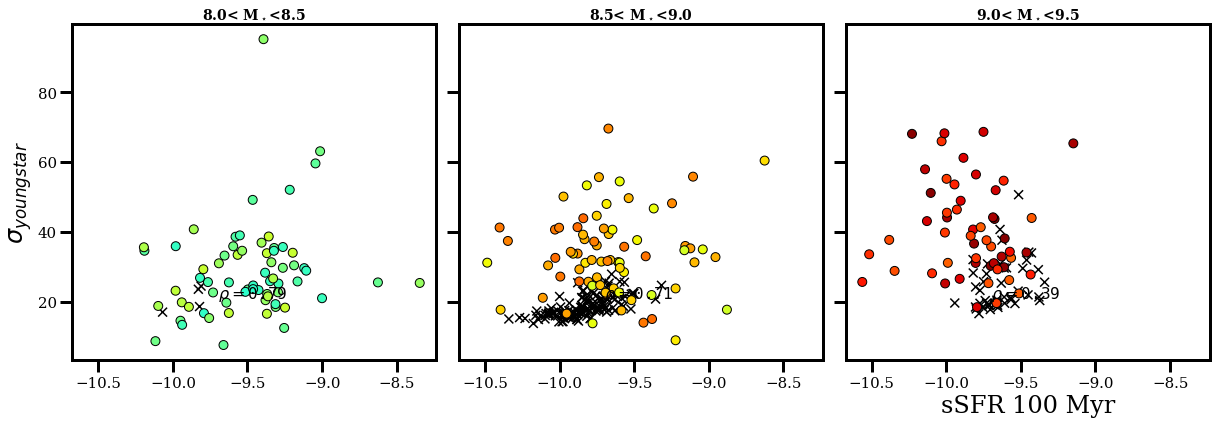

In [35]:
# SIG
fig, axs = plt.subplots(1,3, figsize=(17,6), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [8.0,8.5,9.0,9.5]

for i,ax in enumerate(axs):
    ssfr = []
    sigYS = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galaxies_romulus):
        if gal in [431, 615]: continue
        
        data = pd.read_csv(datapath_romulus+'r'+str(gal)+'_qtys.txt')
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_coldgas_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigYS.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigYS, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

    p = ss.spearmanr(ssfr, sigYS)[0]
    ax.text(s=r'$\rho = $'+str(p)[:4], x=-9.70, y=21, fontsize=16, fontfamily='monospace')
    
    fs = 14
    ax.set_title(str(mstar_min)+'< M$_\star$<'+str(mstar_max), fontsize=fs, weight='bold')
    
    massmask = mass_keck_cut >= mstar_min
    mm = mass_keck_cut[massmask]
    x = ssfr_keck_cut[massmask]
    y = vdisp_keck_cut[massmask]

    massmask = mm<=mstar_max
    mm = mm[massmask]
    x = x[massmask]
    y = y[massmask]

    s=ax.scatter(x, y, c=mm, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5)
    
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='5%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=12, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=12)
    
# prettify 
axs[2].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[0].set_ylabel(r'$\sigma_{youngstar}$', fontsize=24)

plt.tight_layout()

pf = '../figures/keck/ssfr_100_hmr_binned_5.png'
#plt.savefig(pf)

# Romulus and Fire

<ipython-input-38-1b6d36b2c6c7>:71: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-38-1b6d36b2c6c7>:72: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]
<ipython-input-38-1b6d36b2c6c7>:71: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-38-1b6d36b2c6c7>:72: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]
<ipython-input-38-1b6d36b2c6c7>:71: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-38-1b6d36b2c6c7>:72: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]


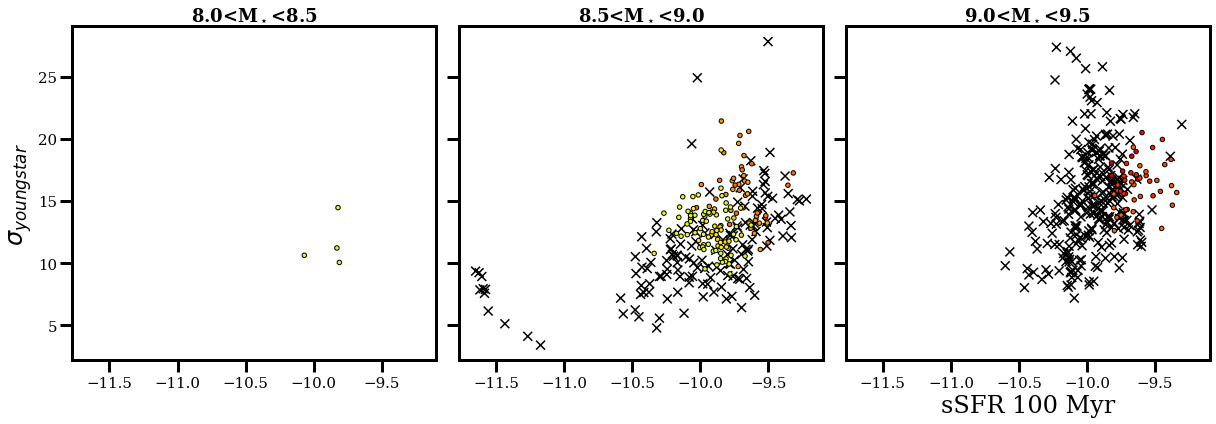

In [38]:
# SIG
fig, axs = plt.subplots(1,3, figsize=(17,6), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [8.0,8.5,9.0,9.5]

for i,ax in enumerate(axs):
    ssfr = []
    sigYS = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galfiles_fire[1:]):
        
        data = pd.read_csv(gal)
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_youngstar_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigYS.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigYS, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)
    
    p = ss.spearmanr(ssfr, sigYS)[0]
    #ax.text(s=r'$\rho = $'+str(p)[:4], x=-11.7, y=27, fontsize=18, fontfamily='monospace')
    
    ax.set_title(str(mstar_min)+'<M$_\star$<'+str(mstar_max), fontsize=18, weight='bold')
    
for i,ax in enumerate(axs):
    ssfr = []
    sigYS = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galaxies_romulus):
        if gal in [431, 615]: continue
        
        data = pd.read_csv(datapath_romulus+'r'+str(gal)+'_qtys.txt')
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_youngstar_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigYS.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigYS, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='.')
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='5%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=12, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=12)
    
# prettify 
axs[2].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[0].set_ylabel(r'$\sigma_{youngstar}$', fontsize=24)

plt.tight_layout()

pf = '../figures/keck/ssfr_100_hmr_binned_5.png'
#plt.savefig(pf)